In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e10/sample_submission.csv
/kaggle/input/playground-series-s5e10/train.csv
/kaggle/input/playground-series-s5e10/test.csv


# Сиды

In [2]:
import numpy as np
import pandas as pd
import random
import os


seed=42

np.random.seed(seed)
os.environ['PYTHONHASHSEED']=str(seed)
random.seed(seed)

# Импорты

In [3]:
from sklearn.model_selection import train_test_split, KFold
try:
    from sklearn.metrics import root_mean_squared_error as root_mean_squared_error
except ImportError:
    from sklearn.metrics import mean_squared_error
    def root_mean_squared_error(y_true, y_pred, sample_weight=None):
        return mean_squared_error(y_true, y_pred, squared=False, sample_weight=sample_weight)
from catboost import Pool, CatBoostRegressor
import matplotlib.pyplot as plt


# Загрузка данных

In [4]:
train=pd.read_csv('/kaggle/input/playground-series-s5e10/train.csv')
test=pd.read_csv('/kaggle/input/playground-series-s5e10/test.csv')
sample=pd.read_csv('/kaggle/input/playground-series-s5e10/sample_submission.csv')

# Нумерики и категорики

In [5]:
useless_feats=['id']

In [6]:
num_feats=train.drop(columns=useless_feats).select_dtypes(include='number').columns.tolist()
cat_feats=train.drop(columns=useless_feats).select_dtypes(include=['object', 'category', 'string']).columns.tolist()

# EDA

In [7]:
train.head()

,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13
1,1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35
2,2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30
3,3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21
4,4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56


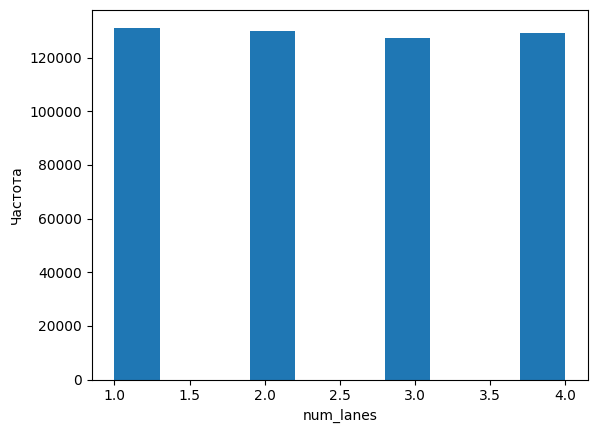

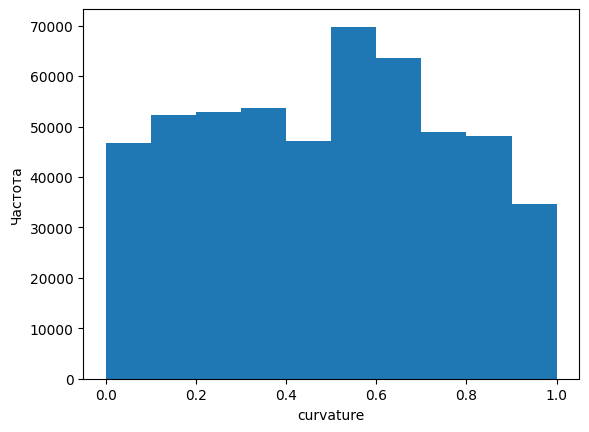

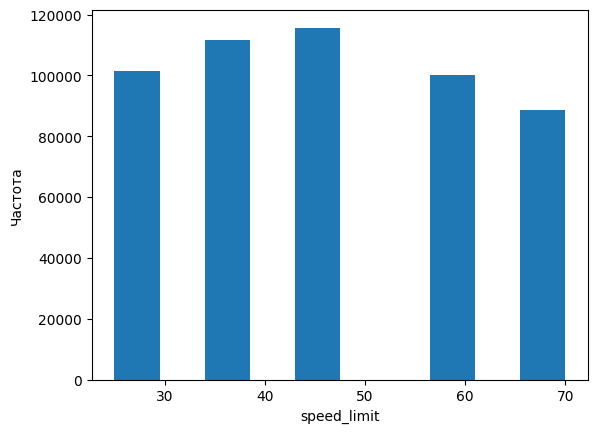

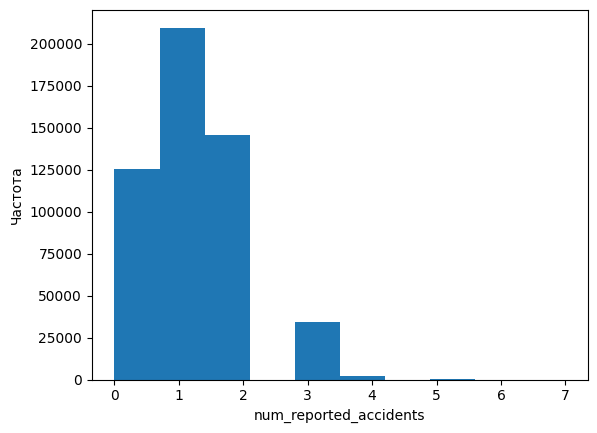

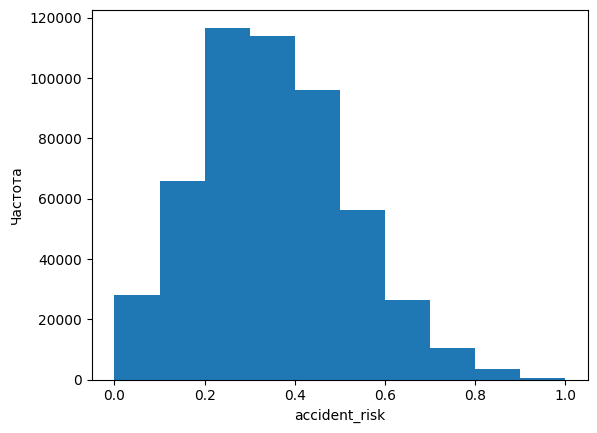

In [8]:
for col in num_feats:
    plt.figure()
    plt.hist( train[col] )
    plt.xlabel(col)
    plt.ylabel('Частота')
    plt.show()

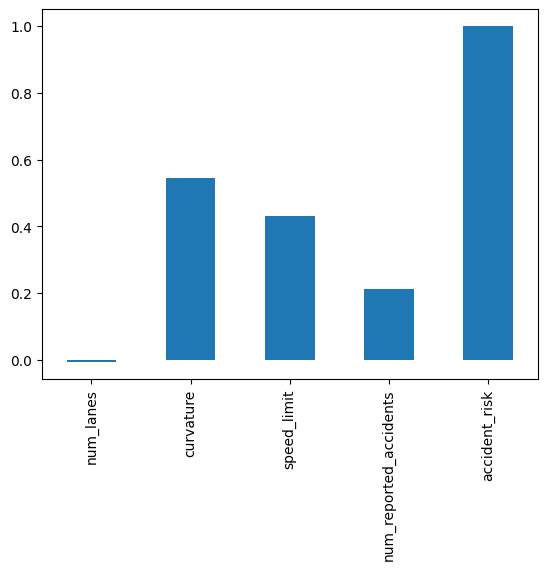

In [9]:
correlation=train[num_feats].corrwith(train['accident_risk'])
correlation.plot(kind='bar')
plt.show()

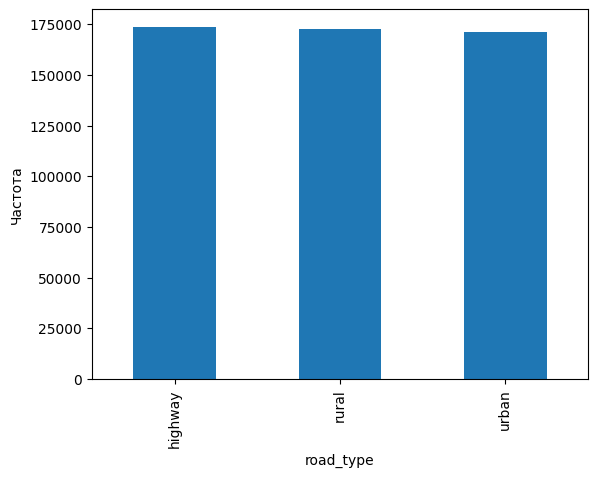

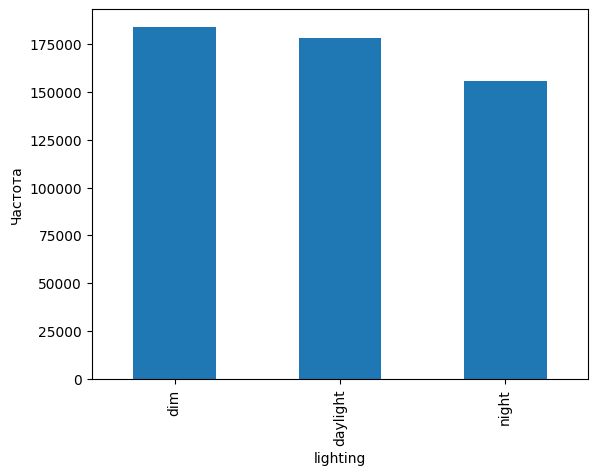

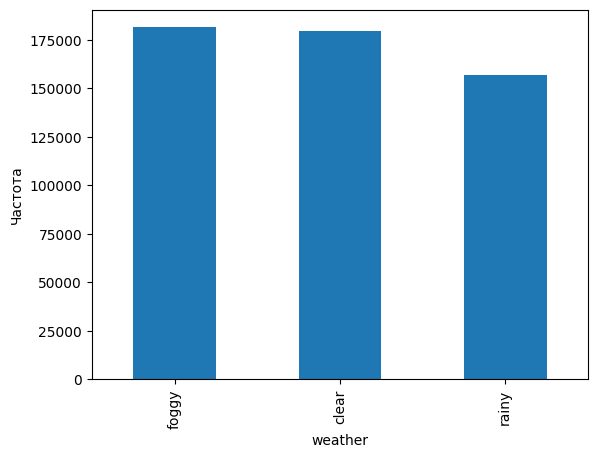

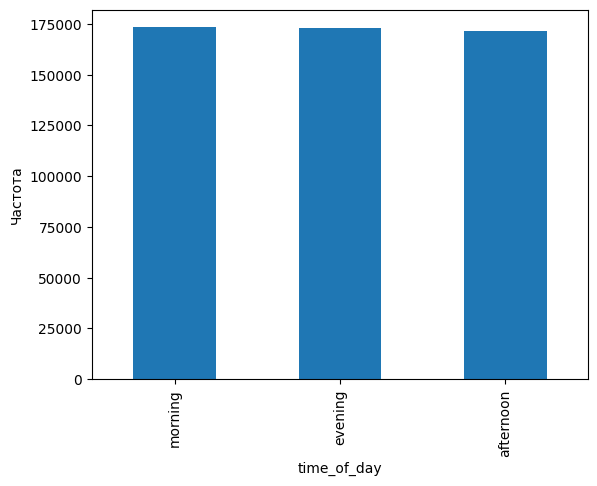

In [10]:
for col in cat_feats:
    counts=train[col].value_counts()
    plt.figure()
    counts.plot(kind='bar')
    plt.xlabel(col)
    plt.ylabel('Частота')

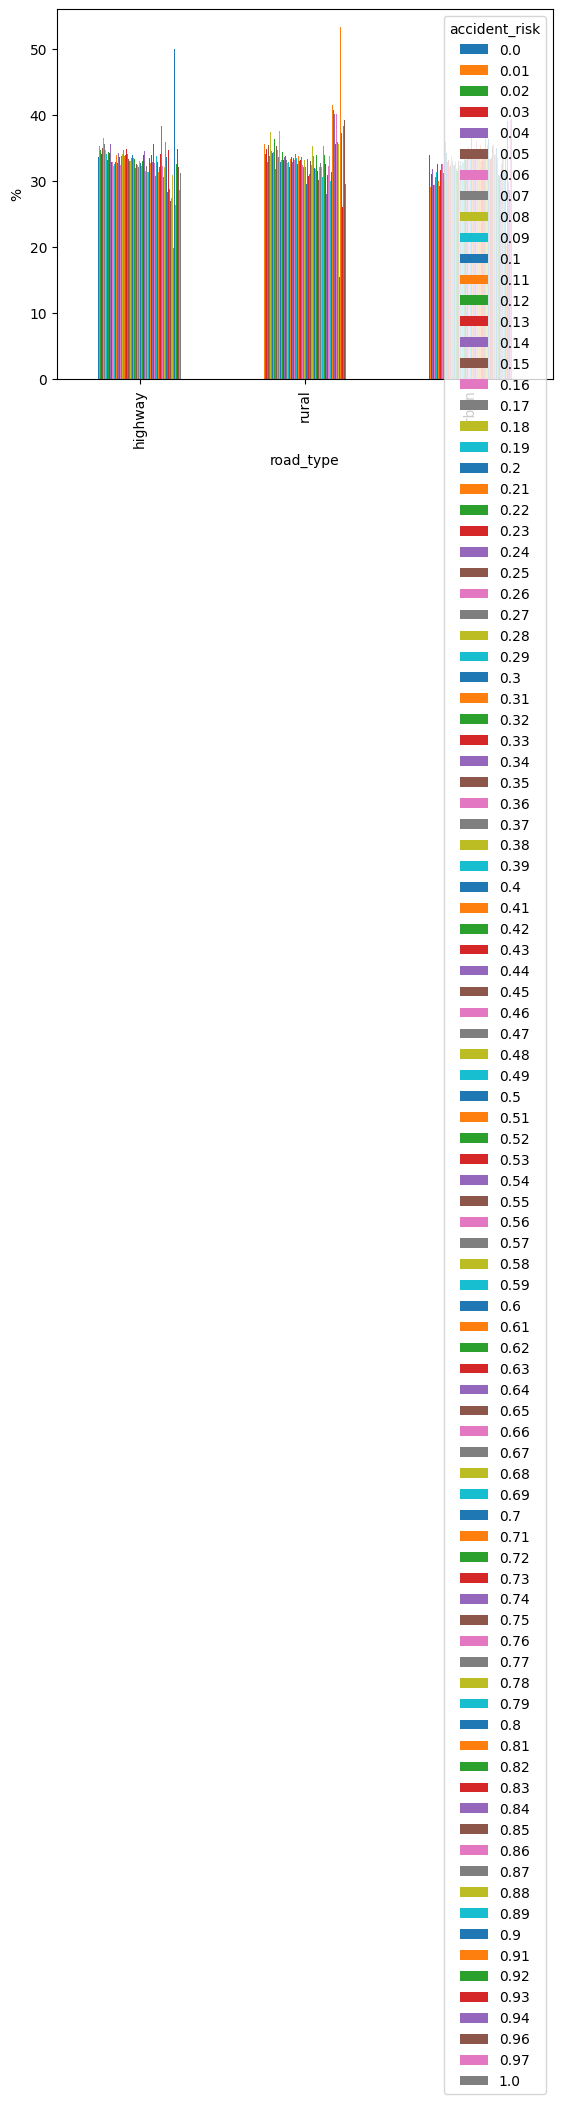

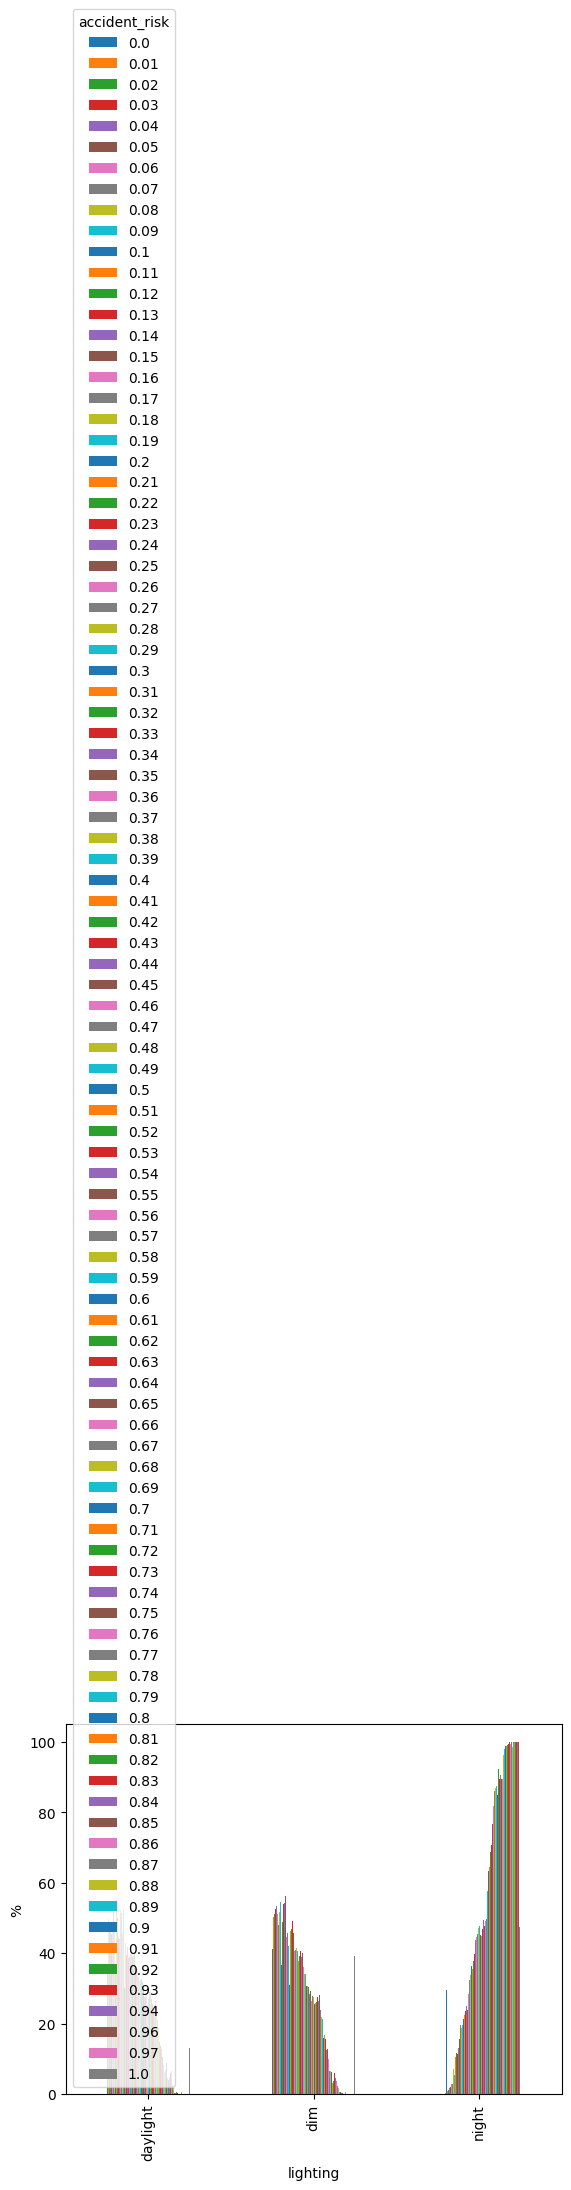

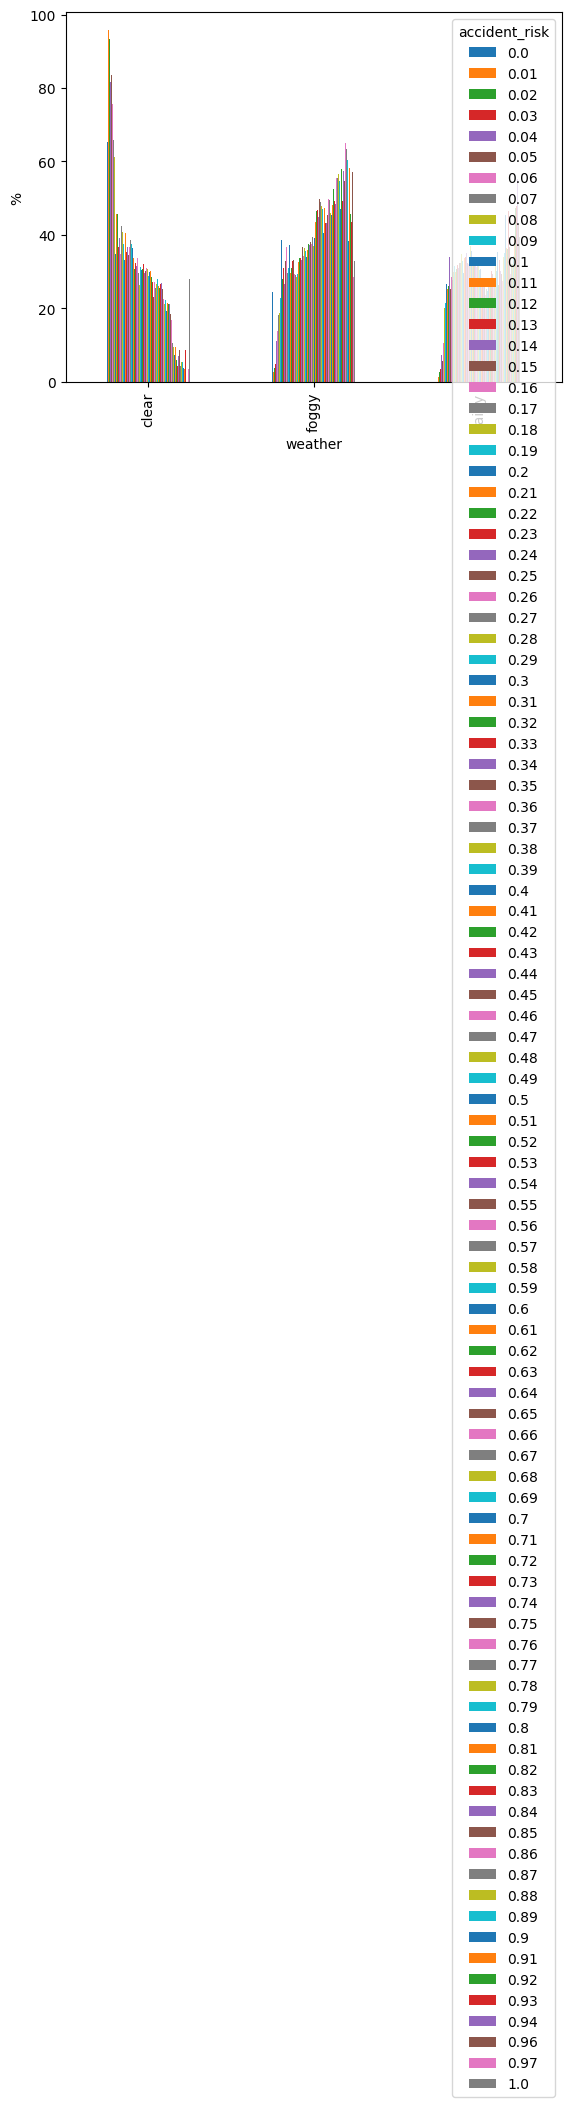

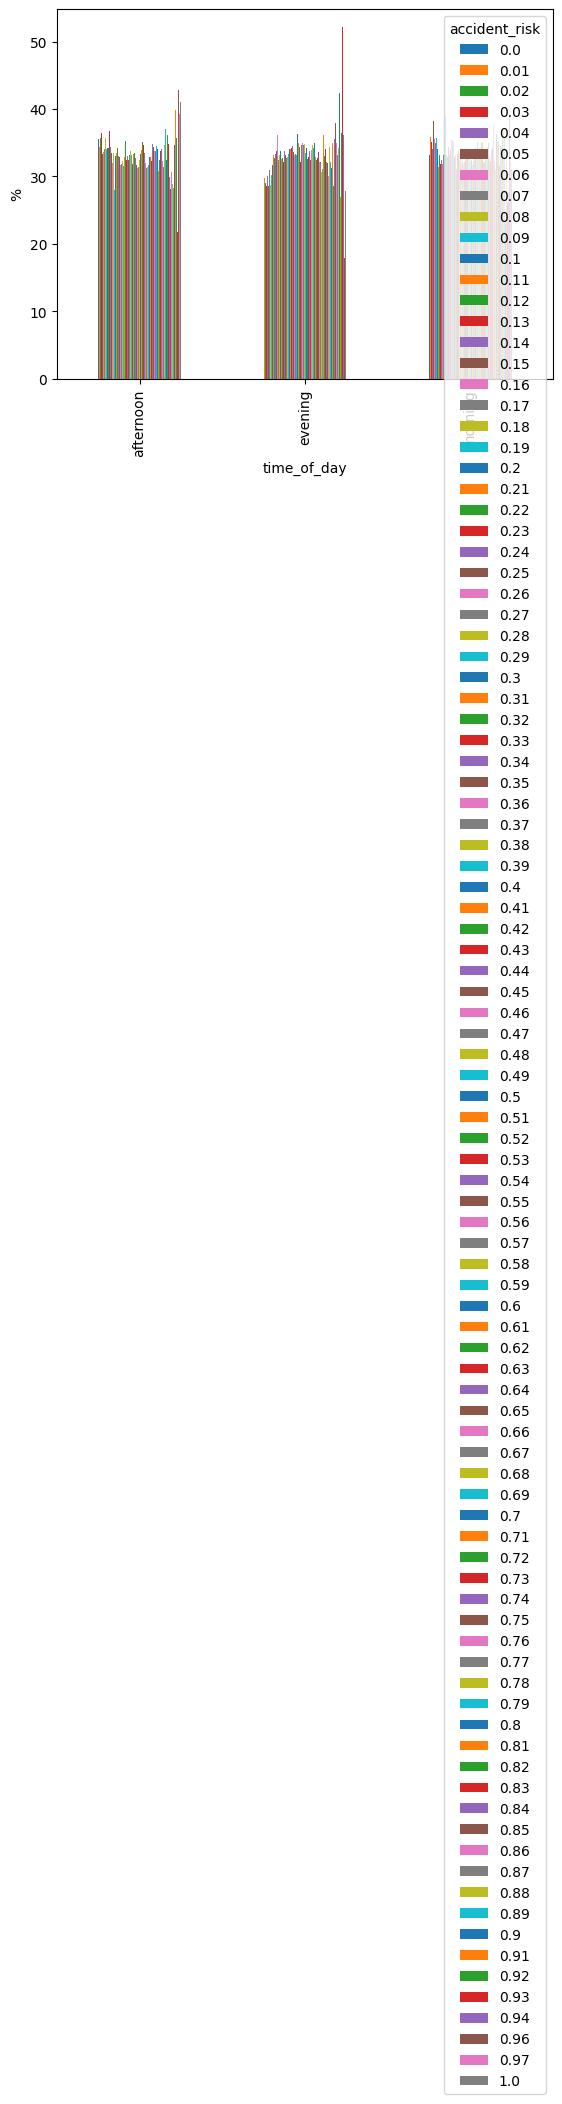

In [11]:
for col in cat_feats:
    car_crt=pd.crosstab(train[col], train['accident_risk'], normalize='columns')*100
    ax=car_crt.plot(kind='bar')
    ax.set_xlabel(col)
    ax.set_ylabel('%')
    plt.show()

# Feature engineering

In [12]:
num_feats

['num_lanes',
 'curvature',
 'speed_limit',
 'num_reported_accidents',
 'accident_risk']

In [13]:
cat_feats

['road_type', 'lighting', 'weather', 'time_of_day']

In [14]:
def featurize(df):
    df['road_signs_present'] = df['road_signs_present'].astype('Int8')
    df['public_road'] = df['public_road'].astype('Int8')
    #df['time_of_day'] = df['time_of_day'].astype('Int8')
    df['holiday'] = df['holiday'].astype('Int8')
    df['school_season'] = df['school_season'].astype('Int8')

    

    
    df['logical_square_1']=df['curvature']**2
    df['logical_square_2']=df['speed_limit']**2
    df['logical_square_3']=df['num_reported_accidents']**2
    #df['logical_square_4']=df['accident_risk']**2
    
    df['logical_sqrt_1']=np.sqrt(df['curvature'])
    df['logical_sqrt_2']=np.sqrt(df['speed_limit'])
    df['logical_sqrt_3']=np.sqrt(df['num_reported_accidents'])
    #df['logical_sqrt_4']=np.sqrt(df['accident_risk'])

    df['logical_mutliplication_1']=df['curvature']*df['speed_limit']
    df['logical_mutliplication_2']=df['num_reported_accidents']*df['speed_limit']
    df['logical_mutliplication_3']=df['curvature']*df['speed_limit']
    df['logical_mutliplication_4']=df['curvature']*df['num_reported_accidents']

    df['logical_ratio_1']=df['curvature']/df['num_reported_accidents']
    df['logical_ratio_2']=df['curvature']/df['speed_limit']
    df['logical_ratio_3']=df['speed_limit']/df['num_reported_accidents']
    df['logical_ratio_4']=df['speed_limit']/df['curvature']

    #space for any creative features my dude 
    #df['']=







    



    
    
    # end of space my dudeeeeeeee

    #kinda multiplication for categorical(if any ofc)

    df['multi_cat_1']=df['road_type'] + '_' + df['weather']
    df['multi_cat_2']=df['lighting'] + '_' + df['time_of_day']
    df['multi_cat_3']=df['weather'] + '_' + df['time_of_day']
    df['multi_cat_4']=df['lighting'] + '_' + df['road_type']


    #squares for categorical  🤡🤡🤡💀💀💀

    #df['square_cat_']=df[''] + '_' + df['']
    #df=df.drop('num_lanes')



    df['risk_1'] = (df['curvature'] * df['speed_limit'] * (df['num_reported_accidents'] + 1)) / (df['num_lanes'] + 1)
    df['risk_2'] = df['speed_limit'] / 25 * (df['curvature'] + 0.1) * (df['num_reported_accidents'] + 1)
    
    # Categorical risk
    df['bad_weather'] = df['weather'].isin(['rainy', 'foggy']).astype(int)
    df['poor_light'] = df['lighting'].isin(['night', 'dim']).astype(int)
    df['weather_light_risk'] = df['bad_weather'] * df['poor_light']
    df['peak_time'] = df['time_of_day'].isin(['morning', 'evening']).astype(int)
    
    # Road encoding
    road_map = {'highway': 2, 'rural': 1, 'urban': 0}
    df['road_level'] = df['road_type'].map(road_map)
    
    # 3-way interactions
    df['speed_curv_acc'] = df['speed_limit'] * df['curvature'] * df['num_reported_accidents']
    
    # Safety
    df['safety'] = df['road_signs_present'].astype(int) * 0.5 + df['public_road'].astype(int) * 0.5
    df['safety_deficit'] = (1 - df['safety']) * df['speed_limit']
    
    # Bins with proper handling
    df['curv_bin'] = pd.cut(df['curvature'], bins=[-0.01, 0.3, 0.6, 1.01], labels=[0, 1, 2]).astype(int)
    df['speed_bin'] = pd.cut(df['speed_limit'], bins=[0, 35, 50, 71], labels=[0, 1, 2]).astype(int)

    return df
    

In [15]:
train_full=featurize(train)
test_full=featurize(test)

# skf catboost

In [16]:
model_cfgs = [
    dict(
        name="GPU_accurate_d8_lr0.03_12k",
        params=dict(
            loss_function="RMSE", eval_metric="RMSE",
            iterations=12000, learning_rate=0.03, depth=8,
            l2_leaf_reg=12.0, random_strength=1.5,
            bootstrap_type="Bayesian", bagging_temperature=0.5,
            leaf_estimation_method="Newton", leaf_estimation_iterations=10,
            one_hot_max_size=32, max_ctr_complexity=2,
            task_type="GPU", devices="0",
            od_type="Iter", od_wait=600, use_best_model=True,
            random_seed=42
        )
    ),
    dict(
        name="GPU_fast_d6_lr0.08_5k",
        params=dict(
            loss_function="RMSE", eval_metric="RMSE",
            iterations=5000, learning_rate=0.08, depth=6,
            l2_leaf_reg=10.0, random_strength=1.0,
            bootstrap_type="Bayesian", bagging_temperature=0.25,
            leaf_estimation_method="Newton", leaf_estimation_iterations=6,
            one_hot_max_size=16, max_ctr_complexity=1,
            task_type="GPU", devices="0",
            od_type="Iter", od_wait=300, use_best_model=True,
            random_seed=42
        )
    ),
    
    dict(
        name="GPU_shallow_noise_robust",
        params=dict(
            loss_function="RMSE", eval_metric="RMSE",
            iterations=14000, learning_rate=0.025, depth=5,
            l2_leaf_reg=24.0, random_strength=2.5,
            bootstrap_type="Bayesian", bagging_temperature=1.0,
            leaf_estimation_method="Newton", leaf_estimation_iterations=6,
            rsm=0.8,
            task_type="GPU", devices="0",
            od_type="Iter", od_wait=700, use_best_model=True,
            random_seed=42
        )
    ),
    dict(
        name="CPU_balanced_d8_lr0.03_10k",
        params=dict(
            loss_function="RMSE", eval_metric="RMSE",
            iterations=10000, learning_rate=0.03, depth=8,
            l2_leaf_reg=12.0, random_strength=1.5,
            bootstrap_type="Bayesian", bagging_temperature=0.5,
            leaf_estimation_method="Newton", leaf_estimation_iterations=10,
            one_hot_max_size=32, max_ctr_complexity=2,
            border_count=254,  # finer binning on CPU
            boosting_type="Ordered",
            thread_count=-1,
            od_type="Iter", od_wait=600, use_best_model=True,
            random_seed=42
        )
    )
]

In [17]:
train_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517754 entries, 0 to 517753
Data columns (total 44 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   id                        517754 non-null  int64  
 1   road_type                 517754 non-null  object 
 2   num_lanes                 517754 non-null  int64  
 3   curvature                 517754 non-null  float64
 4   speed_limit               517754 non-null  int64  
 5   lighting                  517754 non-null  object 
 6   weather                   517754 non-null  object 
 7   road_signs_present        517754 non-null  Int8   
 8   public_road               517754 non-null  Int8   
 9   time_of_day               517754 non-null  object 
 10  holiday                   517754 non-null  Int8   
 11  school_season             517754 non-null  Int8   
 12  num_reported_accidents    517754 non-null  int64  
 13  accident_risk             517754 non-null  f

In [18]:
X=train_full.drop(columns=['accident_risk'])
y=train_full['accident_risk']

In [19]:
cat_feats_full=train_full.select_dtypes(include='object').columns.tolist()

In [20]:
cat_feats_full

['road_type',
 'lighting',
 'weather',
 'time_of_day',
 'multi_cat_1',
 'multi_cat_2',
 'multi_cat_3',
 'multi_cat_4']

In [21]:
skf=KFold(n_splits=5, shuffle=True, random_state=seed) #Or just KFold, one word is the diffirence 
n_models=len(model_cfgs)
n_folds=5
oof_preds=np.zeros((len(y), n_models), dtype=float)
test_preds=np.zeros((len(test_full), n_models), dtype=float)

cv_scores=[]

test_pool=Pool(
    data=test_full,
    cat_features=cat_feats_full
)

for m_idx, cfg in enumerate(model_cfgs):
    name, params=cfg['name'], cfg['params']
    oof_pred=np.zeros(len(y), dtype=float)
    test_pred=np.zeros(len(test_full), dtype=float)
    fold_metric=[]
    for fold, (train_idx, eval_idx) in enumerate(skf.split(X,y), 1):
        X_train=X.iloc[train_idx]
        X_eval=X.iloc[eval_idx]
        y_train=y.iloc[train_idx]
        y_eval=y.iloc[eval_idx]

        train_pool=Pool(
            data=X_train,
            label=y_train,
            cat_features=cat_feats_full,
        
        )
        eval_pool=Pool(
            data=X_eval,
            label=y_eval,
            cat_features=cat_feats_full,
        
        )
        model=CatBoostRegressor(        # ну или Regressor
            **params
        )
        model.fit(train_pool, eval_set=eval_pool, verbose=200, use_best_model=True, early_stopping_rounds=400)
        eval_pred=model.predict(eval_pool)
        oof_pred[eval_idx]=eval_pred
        fold_metric.append(root_mean_squared_error(y_eval, eval_pred))

        test_pred+=model.predict(test_pool)/n_folds
    print(f'CV :{np.mean(fold_metric):.5f} +- {np.std(fold_metric):.5f}')
    oof_preds[:, m_idx]=oof_pred
    test_preds[:, m_idx]=test_pred
    mean_rmse, std_rmse = np.mean(fold_metric), np.std(fold_metric)
    model_cv = (mean_rmse, std_rmse)
    #model_cv=(np.mean(fold_metric), np.std(fold_metric))
    #cv_scores.append(name, *model_cv)
    cv_scores.append((name, mean_rmse, std_rmse))  
    print(f'CV :{model_cv[0]:.5f} ± {model_cv[1]:.5f}')
    

0:	learn: 0.1621370	test: 0.1618463	best: 0.1618463 (0)	total: 15s	remaining: 2d 2h 2m 9s
200:	learn: 0.0562724	test: 0.0565845	best: 0.0565845 (200)	total: 17.6s	remaining: 17m 13s
400:	learn: 0.0559709	test: 0.0564409	best: 0.0564409 (400)	total: 20.2s	remaining: 9m 43s
600:	learn: 0.0557338	test: 0.0563725	best: 0.0563724 (599)	total: 22.8s	remaining: 7m 12s
800:	learn: 0.0555248	test: 0.0563379	best: 0.0563379 (800)	total: 25.4s	remaining: 5m 55s
1000:	learn: 0.0553305	test: 0.0563125	best: 0.0563125 (1000)	total: 28s	remaining: 5m 7s
1200:	learn: 0.0551492	test: 0.0563030	best: 0.0563030 (1200)	total: 30.6s	remaining: 4m 35s
1400:	learn: 0.0549732	test: 0.0562964	best: 0.0562961 (1393)	total: 33.3s	remaining: 4m 11s
1600:	learn: 0.0548037	test: 0.0562914	best: 0.0562904 (1591)	total: 35.9s	remaining: 3m 53s
1800:	learn: 0.0546398	test: 0.0562958	best: 0.0562904 (1591)	total: 38.5s	remaining: 3m 37s
bestTest = 0.05629041276
bestIteration = 1591
Shrink model to first 1592 iterations

CatBoostError: catboost/private/libs/options/catboost_options.cpp:637: Error: rsm on GPU is supported for pairwise modes only

# Submission

# Meta models

In [22]:
colnames=[cfg['name'] for cfg in model_cfgs]
oof_df=pd.DataFrame(oof_preds, columns=colnames)
test_df=pd.DataFrame(test_preds, columns=colnames)

In [23]:
model_cat=CatBoostRegressor( # or Regressor
    iterations=500,
    depth=3,
    learning_rate=0.05,
    l2_leaf_reg=10.0,
    task_type='GPU',
    devices='0',
   loss_function='RMSE',
)

In [24]:
model_cat.fit(oof_df, y, verbose=False)
catboost_test_pred=model_cat.predict(test_df)
sub2=pd.DataFrame({
    'id':sample['id'],
    'accident_risk': catboost_test_pred
})
sub2.to_csv('catboost_as_meta_model_first_try_gol.csv', index=False)


In [ ]:
blend = test_df.mean(axis=1)
sub3=pd.DataFrame({
    'id': sample['id'],
    'accident_risk': blend
})
sub3.to_csv('just_a_blend_oout_of_skf.csv', index=False)